In [2]:
import numpy as np
import robotics.robosuite_src.robosuite as suite

import robotics.robomimic.robomimic.utils.env_utils as EnvUtils
import robotics.robomimic.robomimic.utils.file_utils as FileUtils

from robotics.robosuite_src.robosuite.wrappers.gym_wrapper import GymWrapper


[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)
/home/may33/miniconda3/envs/diffusion/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/may33/miniconda3/envs/diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import json
import h5py

data_path = "../robomimic/datasets/tool_hang/ph/image.hdf5"


f = h5py.File(data_path, "r")

In [2]:
f.keys()

<KeysViewHDF5 ['data', 'mask']>

In [3]:
data = f["data"]

In [16]:
env_name = json.loads(f["data"].attrs["env_args"])

In [ ]:
env_info = json.loads(f["data"].attrs["env_info"])


In [3]:

data_path = "../robomimic/datasets/tool_hang/ph/image.hdf5"

env_meta = FileUtils.get_env_metadata_from_dataset(dataset_path=data_path)

env_meta["env_kwargs"]["has_renderer"] = True
env_meta["env_kwargs"]["camera_widths"] = 224
env_meta["env_kwargs"]["camera_heights"] = 224



# env = GymWrapper(
#     suite.make(
#         env_meta["env_name"],
#         robots=["Panda"],
#         use_camera_obs=True,
#         use_object_obs=True,
#         reward_shaping=False,
#         has_renderer=True,
#         has_offscreen_renderer=True,
#         render_camera="frontview",
#         horizon=1000,
#         ignore_done=False,
#         camera_names="agentview",
#         camera_heights=124,
#         camera_widths=124,
#     )
# )


env = GymWrapper(
    suite.make(
        env_meta["env_name"],
        # "Lift",
        **env_meta["env_kwargs"],
    )
)

env.flatten_obs = False

/home/may33/miniconda3/envs/diffusion/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/may33/miniconda3/envs/diffusion/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [4]:
import torch
from robotics.model_src.diffusion_model import ConditionalUnet1D
from robotics.model_src.visual_encoder import CNNVisualEncoder

obs_horizon = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

visual_encoder = CNNVisualEncoder().to(device)

vision_feature_dim = visual_encoder.get_output_shape()

action_observation_dim = 7

obs_dim = vision_feature_dim + action_observation_dim

action_dim = 7

noise_prediction_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim * obs_horizon,
).to(device)

number of parameters: 1.110684e+08


In [5]:
from pathlib import Path


def load_final_models(visual_encoder, noise_pred_net, ckpt_path, device="cuda"):
    ckpt_path = Path(ckpt_path)
    state = torch.load(ckpt_path, map_location=device)

    visual_encoder.load_state_dict(state["visual_encoder"], strict=True)
    noise_pred_net.load_state_dict(state["noise_pred_net"], strict=True)

    visual_encoder.to(device).eval()
    noise_pred_net.to(device).eval()
    print(f"Loaded weights from {ckpt_path}")


load_final_models(visual_encoder, noise_prediction_net, "../models/robot_v2_cnn_124/model_final.pth")

Loaded weights from ../models/robot_v2_cnn_124/model_final.pth


In [6]:
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

num_diffusion_iters = 100

noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=True,
    prediction_type='epsilon'
)

In [ ]:
from tqdm import tqdm
from collections import deque
obs_deque  = deque(maxlen=obs_horizon)
act_deque  = deque(maxlen=obs_horizon)
rewards    = []
imgs       = []
obs_frames = []
step_idx   = 0
max_steps = 1000

pred_horizon = 8

action_horizon  = 2

obs = env.reset(seed=0)
obs = obs if isinstance(obs, dict) else obs[0]

# obs_frames.append(obs["agentview_image"])
obs_frames.append(np.flip(obs["agentview_image"], axis=0))


for i in range(obs_deque.maxlen):
    obs_deque.append(obs)
    act_deque.append(np.zeros(action_dim, dtype=np.float32))

pbar = tqdm(total=max_steps)
done = False

while not done and step_idx < max_steps:
    img_np = np.array([obs_deque[i]["agentview_image"] for i in range(obs_deque.maxlen)])
    img_np = np.flip(img_np, axis=1).copy()


    img_t = torch.from_numpy(img_np).permute(0, 3, 1, 2).float().to(device) / 255.0 # receive [1, 224, 224, 3] should be -> [1, 3, 224, 224]

    actions_hist = torch.stack(
        [torch.from_numpy(a) for a in list(act_deque)],
        dim=0
    ).to(device)                           # (1, H_a, 7)

    # 6.2 compute visual features + conditioning
    with torch.no_grad():
        img_feat = visual_encoder(img_t)                # (1, C)
        obs_cond = torch.cat([img_feat.flatten(start_dim=0).unsqueeze(0) , actions_hist.flatten(start_dim=0).unsqueeze(0)], dim=1)

        # 6.3 sample a future action sequence via diffusion
        B = 1
        pred_actions = torch.randn((B, pred_horizon, action_dim), device=device)
        noise_scheduler.set_timesteps(num_diffusion_iters)
        for t in noise_scheduler.timesteps:
            noise_pred    = noise_prediction_net(pred_actions, t, global_cond=obs_cond)
            out           = noise_scheduler.step(noise_pred, t, pred_actions)
            pred_actions  = out.prev_sample

    pred_actions = pred_actions.cpu().numpy()[0]


    start = obs_horizon
    end   = start + action_horizon
    action_block = pred_actions[start:end]          # (5, 7)

    for act in action_block:
        obs, rew, done, info, _ = env.step(act)
        # a = env.step(act)
        obs = obs if isinstance(obs, dict) else obs[0]

        obs_deque.append(obs)

        act_deque.append(act.astype(np.float32))

        rewards.append(rew)
        # obs_frames.append(obs["agentview_image"])
        obs_frames.append(np.flip(obs["agentview_image"], axis=0))

        step_idx += 1
        pbar.update(1)
        pbar.set_postfix(reward=float(rew))

        if done or step_idx >= max_steps:
            break

pbar.close()

  0%|          | 0/1000 [00:00<?, ?it/s]Failed to load plugin: '/lib64/libpango-1.0.so.0: undefined symbol: g_once_init_leave_pointer'
/home/may33/miniconda3/envs/diffusion/lib/python3.12/site-packages/glfw/__init__.py:917: GLFWError: (65548) b'Wayland: The platform does not provide the window position'
  warnings.warn(message, GLFWError)
Failed to load plugin: '/lib64/libjson-glib-1.0.so.0: undefined symbol: g_once_init_leave_pointer'
No plugins found, falling back on no decorations
 23%|██▎       | 226/1000 [00:44<02:39,  4.86it/s, reward=0]

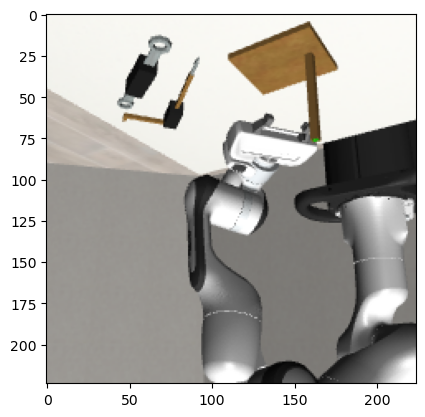

In [7]:
from matplotlib import pyplot as plt

plt.imshow(obs["agentview_image"])

plt.grid(False)

plt.show()

In [10]:
import imageio

video_path = "ne_mogu_smotret.mp4"
fps = 24

with imageio.get_writer(video_path, fps=fps, codec="libx264") as writer:
    for frame in obs_frames:
        writer.append_data(frame)

print(f"Saved video to {video_path}")

Saved video to ne_mogu_smotret.mp4
